#### Library Imports and Required Modules

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from skimage import io, transform

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

#### Define path varibales for the train and test files + train and test labels

In [2]:
pathto_trainimages = '/content/drive/MyDrive/Data Science/Data-Analytics-Cybersecurity/Homeworks/3/hw3-letters-train-images-idx3-ubyte'
pathto_testImages = '/content/drive/MyDrive/Data Science/Data-Analytics-Cybersecurity/Homeworks/3/hw3-letters-test-images-idx3-ubyte'
pathto_trainlabels = '/content/drive/MyDrive/Data Science/Data-Analytics-Cybersecurity/Homeworks/3/hw3-letters-train-labels-idx1-ubyte'
pathto_testlabels = '/content/drive/MyDrive/Data Science/Data-Analytics-Cybersecurity/Homeworks/3/hw3-letters-test-labels-idx1-ubyte'

#### Helper Funtions to generate the dataset from given files

In [3]:
def reshapeImages(imageDict: dict):

  for key in imageDict.keys():
    imageDict[key] = np.array(imageDict[key]).reshape((28, 28))

  return imageDict

def readfiles(filepath):

  with open (filepath, 'rb') as f:
    data_raw = f.read()

  marker = 12
  span = 784
  data = {}
  keystring = 'idx: '

  for i in range (len(data_raw) // span):
    value = data_raw[marker: marker + span]
    data.update({f'{keystring}{i}': value})
    marker = marker + span

  for key in data.keys():
    data[key] = [j for j in data[key]]

  data = reshapeImages(data)

  return data

def readlabels(filepath):

  with open (filepath, 'rb') as f:
    labels_raw = f.read()
    labels_raw = labels_raw[4:]
  marker = 4
  span = 1
  labels = {}
  keystring = 'idx: '

  for i in range (len(labels_raw)):
    value = labels_raw[i]
    labels.update({f'{keystring}{i}': value})

  return labels

def whatsthelength(filepath):
  with open (filepath, 'rb') as fun:
    content = fun.read()
    meta = content[:12]
    length = content[:4]
    length = int.from_bytes(length, byteorder='big', signed=False)

  return length

#### Test whether the helper functions actually work or not

In [4]:
X_train = readfiles(pathto_trainimages)
X_test = readfiles(pathto_testImages)

In [5]:
y_train = readlabels(pathto_trainlabels)
y_test = readlabels(pathto_testlabels)

#### Dataset Class

In [6]:
class custom_MNIST_dataset(Dataset):
    """MNIST dataset provided for Homework 3"""

    def __init__(self, path_binary_data, path_binary_labels, transform=None):

      self.trainData = readfiles(path_binary_data)
      self.labels = readlabels(path_binary_labels)
      self.transform = transform
      self.path_binary_data = path_binary_data
      self.path_binary_labels = path_binary_labels

    def __len__(self):
      with open (self.path_binary_data, 'rb') as f:
        content = f.read()
        meta = content[:12]
        length = content[:4]
        length = int.from_bytes(length, byteorder='big', signed=False)
        return length

    def __getitem__(self, idx):

        returndata = self.trainData[f'idx: {idx}']
        returndata = np.array(returndata, dtype= np.single)
        #returndata = np.array(returndata)
        returnlabel = self.labels[f'idx: {idx}']
        if self.transform != None:
          returndata = self.transform(returndata)


        return returndata, returnlabel

#### Plot for the first 20 images

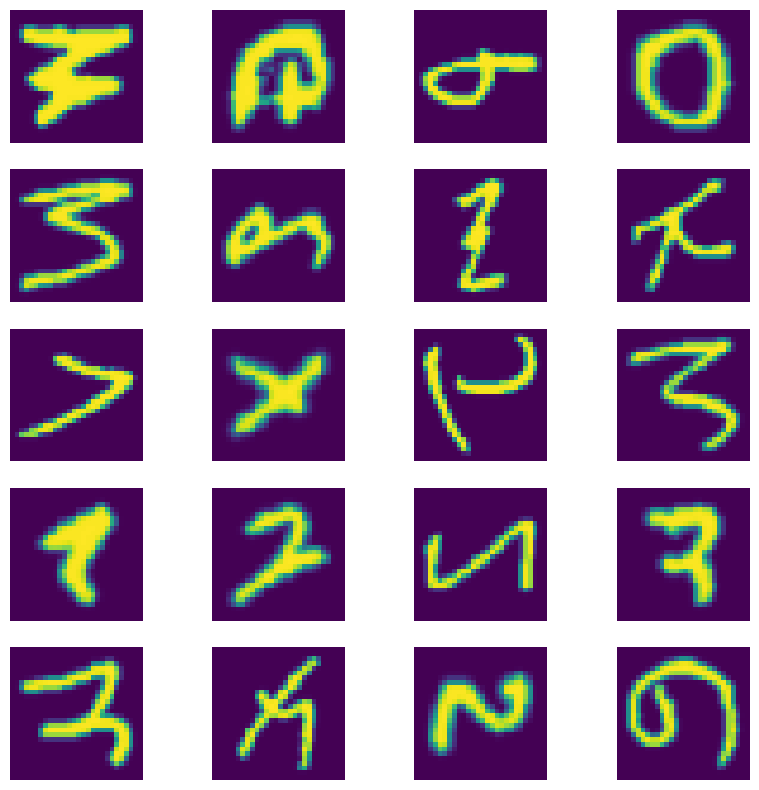

In [7]:
keys = list(X_train.keys())
fig = plt.figure(figsize=(10, 10))
count = 1
rows = 5
columns = 4
for i in range(20):
  fig.add_subplot(rows, columns, count)
  plt.imshow(X_train[keys[i]])
  plt.axis('off')
  count = count + 1

#### Build Model

In [8]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 10

IMG_SIZE = 28
N_CLASSES = 27

#### Training device selection - CPU or GPU

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
%config InlineBackend.figure_format = 'retina'

#### Training Functions

In [11]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n, predicted_labels, y_true

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc, y_train_pred, y_train_true = get_accuracy(model, train_loader, device=device)
            valid_acc, y_valid_pred, y_valid_true = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses), y_train_pred, y_train_true, y_valid_pred, y_valid_true

#### Data Loader

In [12]:
transform = transforms.ToTensor()

In [13]:
train_dataset = custom_MNIST_dataset(pathto_trainimages, pathto_trainlabels, transform = transform)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [14]:
valid_dataset = custom_MNIST_dataset(pathto_testImages, pathto_testlabels, transform = transform)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [15]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [16]:
# for i_batch, sample_batched in enumerate(train_loader):
#   print(type(i_batch))
#   print(np.array(sample_batched).shape)
#   break

# for i, sample in enumerate(train_dataset):
#   print(i)
#   print(sample)
#   break

#### Model Architecture

In [17]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [18]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

#### Train the Model

00:55:10 --- Epoch: 0	Train loss: 0.5402	Valid loss: 0.3185	Train accuracy: 90.44	Valid accuracy: 89.82
00:55:32 --- Epoch: 1	Train loss: 0.2796	Valid loss: 0.2694	Train accuracy: 92.26	Valid accuracy: 91.18
00:55:53 --- Epoch: 2	Train loss: 0.2435	Valid loss: 0.2625	Train accuracy: 92.65	Valid accuracy: 91.55
00:56:12 --- Epoch: 3	Train loss: 0.2209	Valid loss: 0.2559	Train accuracy: 93.15	Valid accuracy: 91.62
00:56:31 --- Epoch: 4	Train loss: 0.2057	Valid loss: 0.2482	Train accuracy: 93.28	Valid accuracy: 92.10
00:56:50 --- Epoch: 5	Train loss: 0.1955	Valid loss: 0.2597	Train accuracy: 93.54	Valid accuracy: 91.55
00:57:09 --- Epoch: 6	Train loss: 0.1878	Valid loss: 0.2456	Train accuracy: 94.10	Valid accuracy: 92.25
00:57:37 --- Epoch: 7	Train loss: 0.1782	Valid loss: 0.2442	Train accuracy: 94.49	Valid accuracy: 92.27
00:57:58 --- Epoch: 8	Train loss: 0.1736	Valid loss: 0.2435	Train accuracy: 94.38	Valid accuracy: 92.27
00:58:17 --- Epoch: 9	Train loss: 0.1671	Valid loss: 0.2498	Trai

<ipython-input-11-fd8bcd2db37e>:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


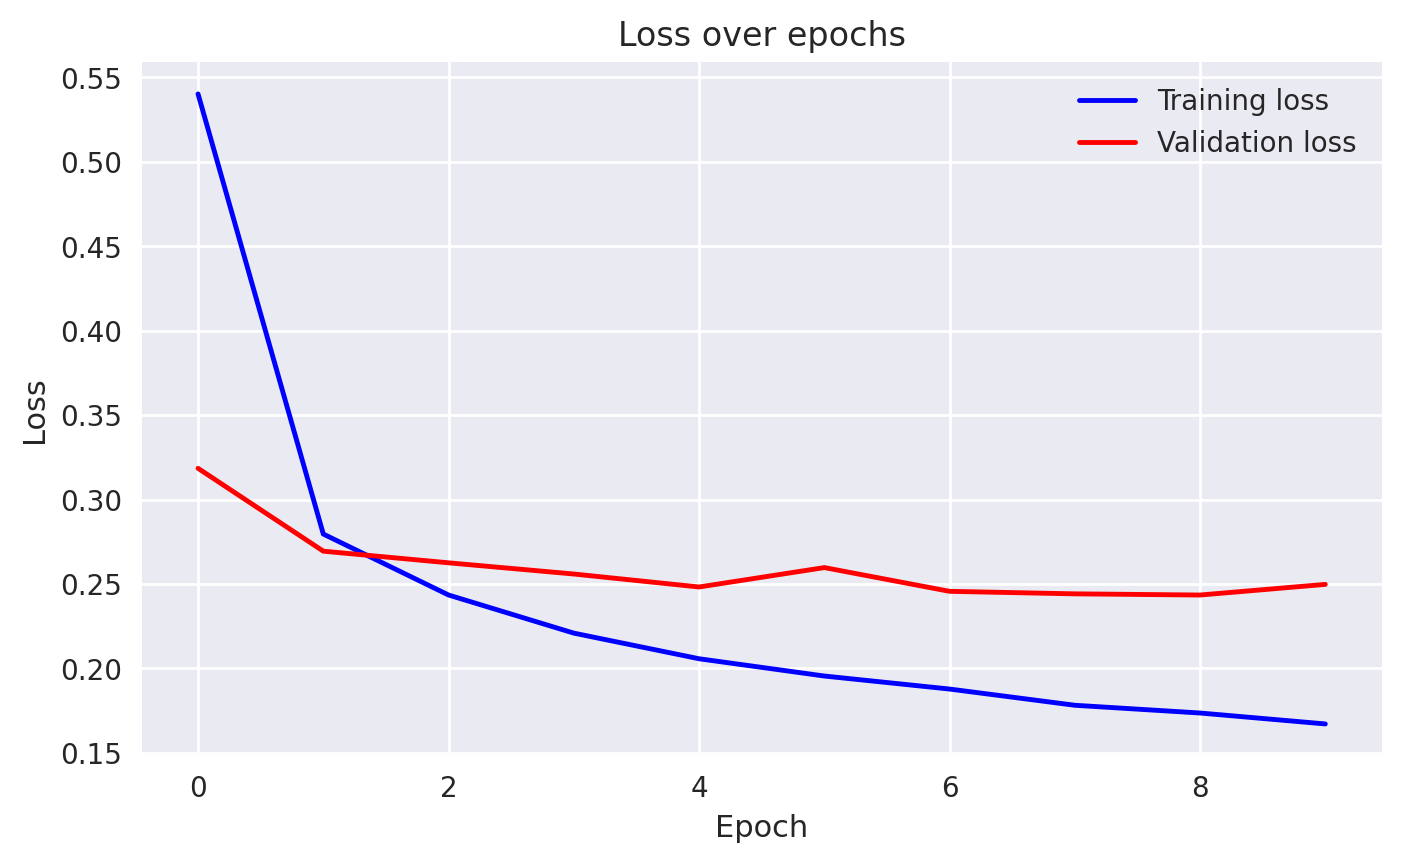

In [19]:
model, optimizer, _, labels_train_pred, labels_train_true, labels_valid_pred, labels_valid_true= training_loop(model, criterion,
                                                                optimizer, train_loader,
                                                                valid_loader, N_EPOCHS,
                                                                DEVICE)

#### Save Model

In [20]:
PATH = '/content/drive/MyDrive/Data Science/Data-Analytics-Cybersecurity/Homeworks/3/model10_new.pth'
torch.save(model.state_dict(), PATH)

In [21]:
labels_valid_pred.shape

torch.Size([32])

In [22]:
labels_valid_true

tensor([18,  2, 12,  5, 21,  7, 23,  4,  2, 21, 12,  3,  3, 21, 25, 11, 12, 20,
         8, 12, 13, 14, 13, 16, 20, 25, 16,  9, 17, 25,  7,  8],
       device='cuda:0')

**NOTE: CPU took 15 minutes | GPU took 4 minutes -> 14 epochs**

This difference changes exponentially w.r.t the increasing epoch number

In [23]:
model = LeNet5(27)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=27, bias=True)
  )
)

#### Load Predictions for Confusion Matrix

In [58]:
y_preds = []
cpuLenet = model.to('cpu')
for i, image in enumerate(valid_dataset):
  imagetensor = image[0].unsqueeze(0)
  # print(type(imagetensor))
  preds = int(torch.argmax(cpuLenet(imagetensor)[1]))
  y_preds.append(preds)

  if i == 20799:
    break

# print(len(y_preds))

In [59]:
len(valid_dataset)

20800

In [60]:
len(y_preds)

20800

#### Confusion Matrix

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [47]:
cm = confusion_matrix(list(y_test.values()), y_preds)

In [50]:
cm_df = pd.DataFrame(cm,
                     index = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                     'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                     columns = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                     'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

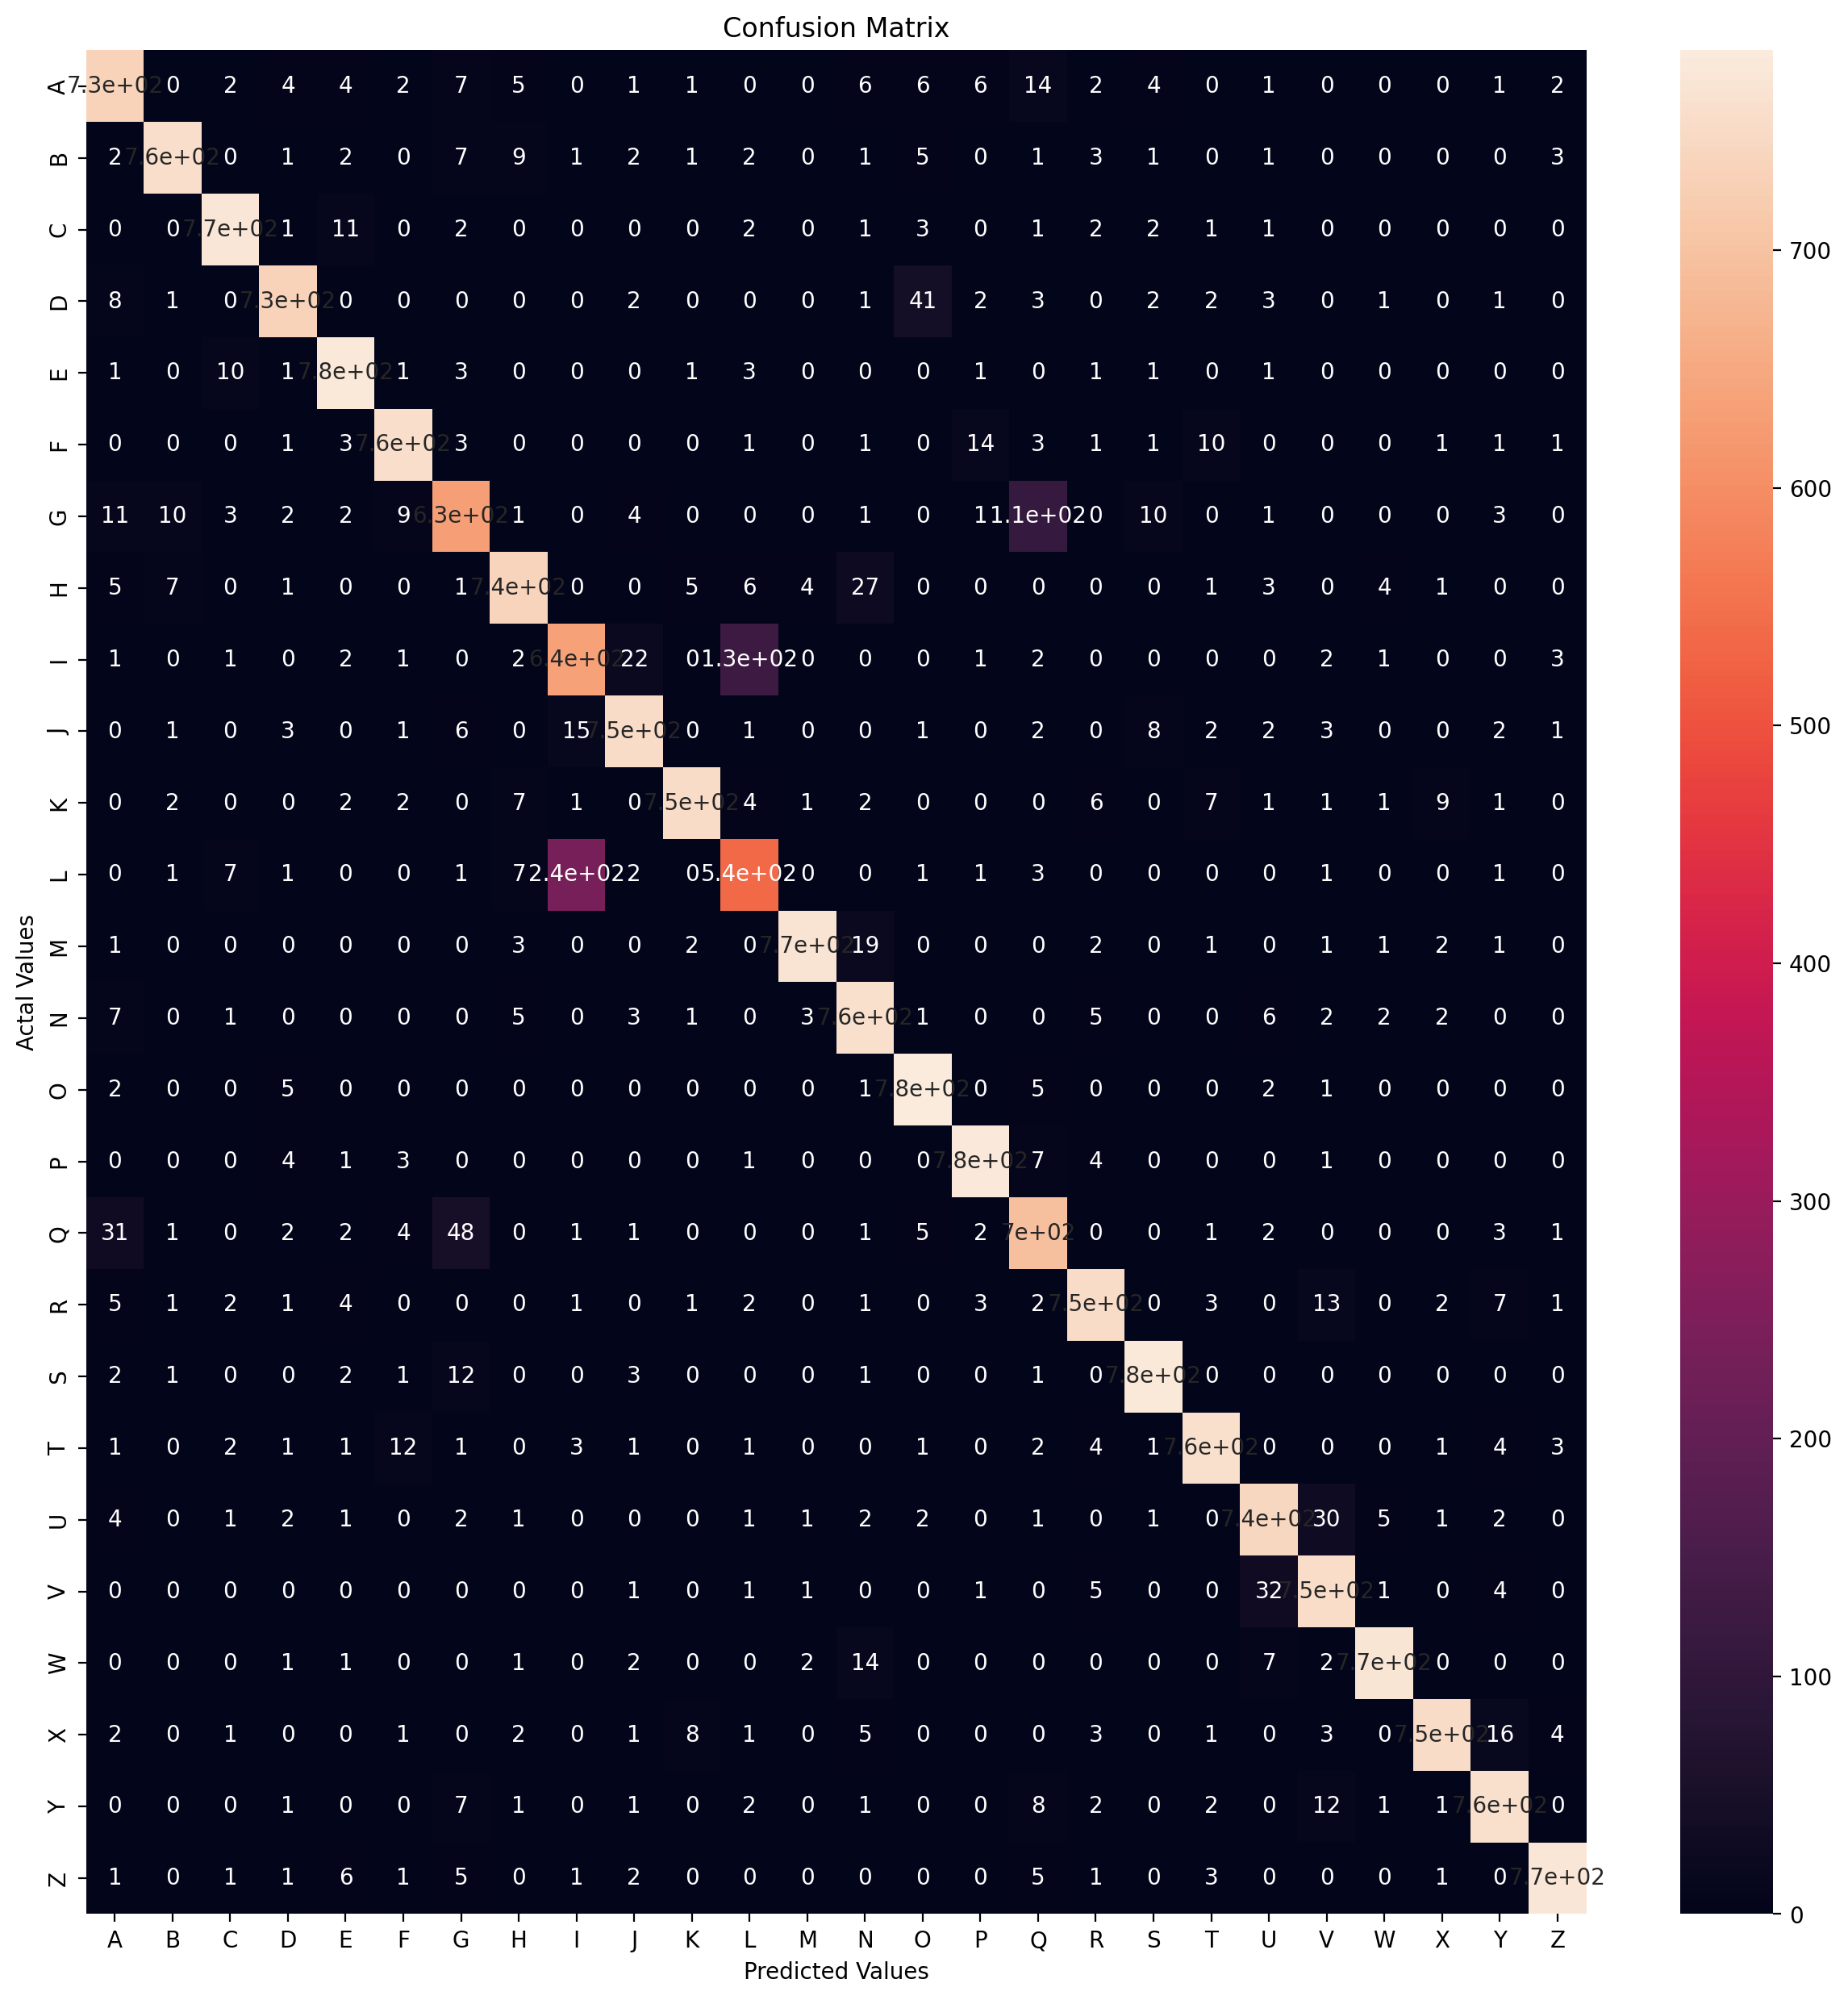

In [62]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

**INFOBAR: FINAL Train accuracy: 94.47	Valid accuracy: 92.32**